# Sentence Similarity: Pretrained
Skyeler McQueen

skyelerm@umich.edu

In this file, I use the pretrained models to find sentence similarity, with no fine-tuning.

In [1]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Here I load the data and split it into test, train, and dev. Training is 70% of the data, test 20%, and dev 10%.

In [2]:
data = pd.read_csv('sbertdata.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
train_df, other_df = train_test_split(data, test_size=.3, random_state=13,stratify=data['similarity'])

In [4]:
test_df, dev_df = train_test_split(other_df, test_size=.333,random_state=13,stratify=other_df['similarity'])

In [5]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
dev_df.dropna(inplace=True)

In [6]:
device = 'mps'

Create the model using 'all-mpnet-base-v2'.

In [7]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

Preprocess the data.

In [9]:
quotes = set(train_df['quote_x'].unique())
y_quotes = set(train_df['quote_y'].unique())

quotes.update(y_quotes)

Update the embeddings.

In [10]:
embeddings = model.encode(list(quotes))

/Users/Skyeler/anaconda3/envs/si649f23/lib/python3.11/site-packages/transformers/models/mpnet/modeling_mpnet.py:1054: UserWarning: cumsum_out_mps supported by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UnaryOps.mm:406.)
  incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask


Let's explore one example!

In [11]:
x=train_df.iloc[0]['quote_x']
y=train_df.iloc[0]['quote_y']

In [12]:
x_emb = model.encode(x,convert_to_tensor=True)
y_emb = model.encode(y,convert_to_tensor=True)

In [13]:
cosine_scores = util.cos_sim(x_emb, y_emb)
cosine_scores.item()

0.06742435693740845

Now I want to apply the model to our dev dataset so that we can choose a threshold.

In [14]:
def get_similarity(row:pd.Series)->float:
    '''This function gets the similarity between two quotes in a row.
    
    Keyword Argument:
    row -- pd.Series, a row with columns 'quote_x' and 'quote_y'
    '''
    x=row['quote_x']
    y=row['quote_y']
    x_emb = model.encode(x,convert_to_tensor=True)
    y_emb = model.encode(y,convert_to_tensor=True)
    cosine_scores = util.cos_sim(x_emb, y_emb)
    return cosine_scores.item()

In [15]:
dev_df['all-mpnet-base-v2'] = dev_df.apply(get_similarity,axis=1)

Now I need to select the correct 'threshold' value to maximize the F1 score.

Text(0.5, 1.0, 'Threshold Values and Dev F1 Scores')

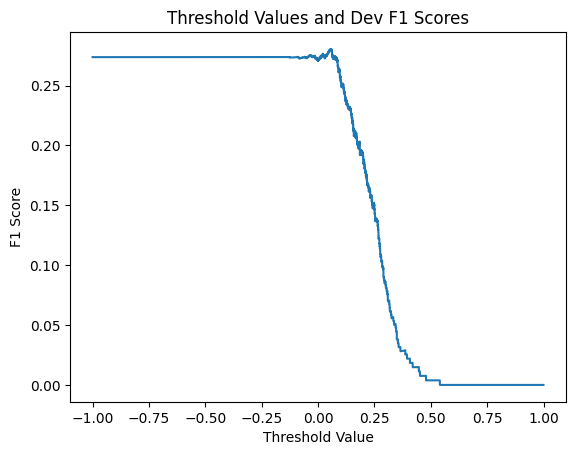

In [16]:
thres_f1 = {}
thres_train = {}
for x in range(-10000,10000):
    threshold = x/10000
    temp = dev_df['all-mpnet-base-v2'].apply(lambda x: 1 if x >= threshold else 0)
    f1 =f1_score(dev_df['similarity'], temp)
    thres_f1[threshold]=f1
    

plot = sns.lineplot(x=list(thres_f1.keys()),y=list(thres_f1.values()))
plot.set_xlabel('Threshold Value')
plot.set_ylabel('F1 Score')
plot.set_title('Threshold Values and Dev F1 Scores')

In [98]:
max_threshold = max(thres_f1, key=thres_f1.get)
print('Threshold: ',max_threshold)
print('F1 Score: ',thres_f1[max_threshold])

Threshold:  0.0558
F1 Score:  0.2806282722513089


In [18]:
thres_f1[.5]

0.00380952380952381

The highest F1 score per threshold value was .2806, with a threshold of .0558. With a threshold of .5 (which would be rounding), the F1 score is .0038. Using the similarity threshold of .2806 is much more effective than rounding.

Now I want to attempt using the mini model instead of the base model.

In [19]:
mini_model = SentenceTransformer("all-MiniLM-L6-v2")
mini_embeddings = mini_model.encode(list(quotes))

In [20]:
def get_mini_similarity(row:pd.Series)->float:
    '''This function gets the similarity between two quotes in a row.
    
    Keyword Argument:
    row -- pd.Series, a row with columns 'quote_x' and 'quote_y'
    '''
    x=row['quote_x']
    y=row['quote_y']
    x_emb = mini_model.encode(x,convert_to_tensor=True)
    y_emb = mini_model.encode(y,convert_to_tensor=True)
    cosine_scores = util.cos_sim(x_emb, y_emb)
    return cosine_scores.item()

In [21]:
dev_df['mini_cosine_sim'] = dev_df.apply(get_mini_similarity,axis=1)

In [22]:
mini_thres_f1 = {}
for x in range(-10000,10000):
    threshold = x/10000
    temp = dev_df['mini_cosine_sim'].apply(lambda x: 1 if x >= threshold else 0)
    f1 =f1_score(dev_df['similarity'], temp)
    mini_thres_f1[threshold]=f1

Text(0.5, 1.0, 'Threshold Values and Dev F1 Scores')

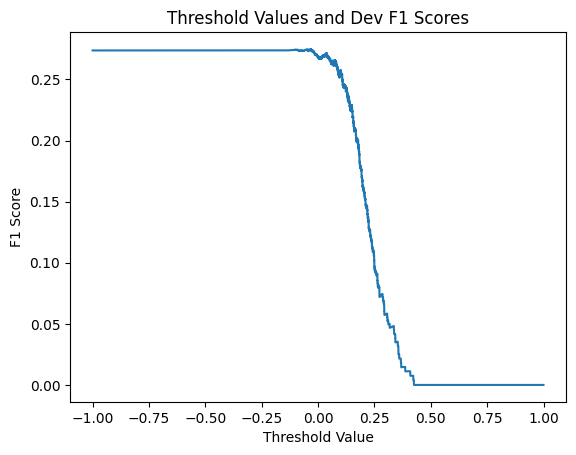

In [23]:
plot = sns.lineplot(x=list(mini_thres_f1.keys()),y=list(mini_thres_f1.values()))
plot.set_xlabel('Threshold Value')
plot.set_ylabel('F1 Score')
plot.set_title('Threshold Values and Dev F1 Scores')

In [26]:
max_threshold = max(mini_thres_f1, key=mini_thres_f1.get)
print('Dev')
print('Threshold: ',max_threshold)
print('F1 Score: ',mini_thres_f1[max_threshold])

Dev
Threshold:  -0.0341
F1 Score:  0.27501366867140514


In [29]:
test_df['mini_cosine_sim'] = test_df.apply(get_mini_similarity,axis=1)

In [30]:
print('Test')
print('Threshold F1 Score: ',f1_score(test_df['similarity'],test_df['mini_cosine_sim'].apply(lambda x: 1 if x >= max_threshold else 0)))
print('Rounded F1 Score: ',f1_score(test_df['similarity'],test_df['mini_cosine_sim'].apply(lambda x: round(x))))

Test
Threshold F1 Score:  0.2732001094990419
Rounded F1 Score:  0.005703422053231939


### Results of Untrained Models

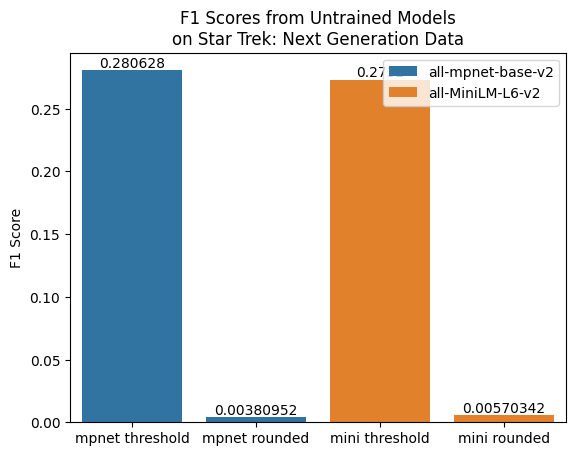

In [33]:
f1scores = [0.2806282723,0.00380952381,0.2732001095,0.005703422053]
models = ['all-mpnet-base-v2','all-mpnet-base-v2','all-MiniLM-L6-v2','all-MiniLM-L6-v2']
rounding = ['mpnet threshold','mpnet rounded','mini threshold','mini rounded']

ax = sns.barplot(x=rounding,y=f1scores,hue=models)
ax.set_title('F1 Scores from Untrained Models\non Star Trek: Next Generation Data')
ax.set_ylabel('F1 Score')

for i in ax.containers:
    ax.bar_label(i,)